# Import modules

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CpgIslands

In [2]:
cpg_islands = pd.read_csv('cpgIslandExt.txt', sep = '\t', header = None) # read the file

cpg_islands = cpg_islands.iloc[:, 1:4] # extract the start and end coordinates of each chr

cpg_islands = cpg_islands.rename(columns = {1 : 'chr', 2 : 'start', 3 : 'end'}) # add columns names
cpg_islands = cpg_islands.sort_values(['chr', 'start', 'end']) # sort by chromosome name then by start then by end
start_list = cpg_islands.groupby(['chr'])['start'].apply(list)
end_list = cpg_islands.groupby(['chr'])['end'].apply(list)
cpg_islands.head()

,chr,start,end
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544


# Read chromosomes length

In [3]:
chrom_len = pd.read_csv('hg19.chrom.sizes.txt', sep = '\t', header = None)
chrom_len = chrom_len.rename(columns = {0 : 'chr', 1 : 'length'})
chrom_len = chrom_len.groupby(['chr'])['length'].apply(int)

# Read DNA Methylation coordinates

In [4]:
dna_methylation = {} # dictionary chromosome => list of tuples
with open("HAIB.A549.EtOH.Rep.3.bed")as f:
    for line in f:
        content = line.strip().split()
        chromosome = content[0]
        start = content[1]
        end = content[2]
        if chromosome in dna_methylation:
            dna_methylation[chromosome].append((int(start) + int(end)) / 2)
        else:
            dna_methylation[chromosome] = [(int(start) + int(end)) / 2]

## Find the Cpg-islands, shores and shelves

In [5]:
def create_data(cpg_start_map, cpg_end_map, window):
    
    cpg_islands = {}
    shores = {}
    shelves = {}
    seas = {}
    keys = list(cpg_start_map.keys())
    for chromosome in keys:
        chromosome_len = chrom_len[chromosome]
        length = len(cpg_start_map[chromosome])
        
        cpg_start = cpg_start_map[chromosome]
        cpg_end = cpg_end_map[chromosome]
        
        shores[chromosome] = [()]  # just define the type of dictionary values to be tuples
        shores[chromosome].remove(())
        
        shelves[chromosome] = [()]
        shelves[chromosome].remove(())
        
        seas[chromosome] = [()]
        seas[chromosome].remove(())
        
        cpg_islands[chromosome] = [()]
        cpg_islands[chromosome].remove(())
        

        # first cpg island
        cpg_islands[chromosome].append((cpg_start[0], cpg_end[0]))
        if cpg_start[0] > (2*window):  # space for shore, shelve and sea
            seas[chromosome].append((0, cpg_start[0] - 2*window))
            shelves[chromosome].append((cpg_start[0] - 2*window, cpg_start[0] - window))
            shores[chromosome].append((cpg_start[0] - window, cpg_start[0]))
        elif cpg_start[0] > (window):    # space for shore and shelve
            shelves[chromosome].append((0, cpg_start[0] - window))
            shores[chromosome].append((cpg_start[0] - window, cpg_start[0]))  
        elif cpg_start[0] < (window):    # space for shore only
            shores[chromosome].append((0, cpg_start[0]))
        
        
        prev_end = cpg_end[0]
        for i in range(1, length):
            start = cpg_start[i]
            end = cpg_end[i]
            
            if start - prev_end > (4*window): # space for shores, shelves and seas
                shores[chromosome].append((prev_end, prev_end + window))
                shelves[chromosome].append((prev_end + window, prev_end + 2*window))
                seas[chromosome].append((prev_end + 2*window, start - 2*window))
                shelves[chromosome].append((start - 2*window, start - window))
                shores[chromosome].append((start - window, start))
            elif start - prev_end > (2*window): # space for shores and shelves
                shores[chromosome].append(( prev_end, prev_end + window))
                shelves[chromosome].append((prev_end + window, start - window))
                shores[chromosome].append((start - window, start))                
            else: # space for shore only
                shores[chromosome].append((prev_end, start))
            
            prev_end = end
            cpg_islands[chromosome].append((start, end))
        
        # last cpg island
          
            # Last CPG Island - Right
        if chromosome_len - prev_end > (2*window):
            shores[chromosome].append((prev_end, prev_end + window))
            shelves[chromosome].append((prev_end + window, prev_end + 2*window))
            seas[chromosome].append((prev_end + 2*window, chromosome_len))
        elif chromosome_len - prev_end > (window):
            shores[chromosome].append((prev_end, prev_end + window))
            shelves[chromosome].append((prev_end + window, chromosome_len))
        elif chromosome_len - prev_end <= (window):
            shores[chromosome].append((prev_end, chromosome_len))
    return cpg_islands, shores, shelves, seas

In [6]:
cpg_islands, shores, shelves, seas = create_data(start_list, end_list, 2000)

## Save data

In [7]:
def save_values_bed(path, data):
    with open(path+'.bed', 'w') as f:
        for key in data.keys():
            for row in data[key]:
                f.write('%s\t%s\t%s\n' % (key, row[0], row[1]))
            

In [8]:
save_values_bed('cpg_islands', cpg_islands)
save_values_bed('shores', shores)
save_values_bed('shelves', shelves)
save_values_bed('seas', seas)

## Binary seach

In [32]:
def binary_search(lst, val):
    
    start = 0
    end = len(lst) - 1
    ret = 0
    while (start <= end):
        mid = int((start + end) / 2)
        
        if lst[mid][0] < val:
            ret = mid
            start = mid + 1
        elif lst[mid][0] > val:
            end = mid - 1
        else:
            ret = mid
            return ret
    return ret
            

## Count the hits per region

In [52]:
def count_hits(cpg_islands, shores, shelves, seas, dna_methylation):
    
    cpg_islands_cnt = 0
    shores_cnt = 0
    shelves_cnt = 0
    seas_cnt = 0
    
    for chromosome in dna_methylation.keys():
        
        for middle in dna_methylation[chromosome]: # binary search the first segment which may contains the methylation point for each region
            
            shore_idx = binary_search(shores[chromosome], middle)
            shores_cnt = shores_cnt + int(shores[chromosome][shore_idx][0] <= middle and shores[chromosome][shore_idx][1] >= middle)
            
            shelve_idx = binary_search(shelves[chromosome], middle)
            shelves_cnt = shelves_cnt + int(shelves[chromosome][shelve_idx][0] <= middle and shelves[chromosome][shelve_idx][1] >= middle)
            
            cpg_island_idx = binary_search(cpg_islands[chromosome], middle)
            cpg_islands_cnt = cpg_islands_cnt + int(cpg_islands[chromosome][cpg_island_idx][0] <= middle and cpg_islands[chromosome][cpg_island_idx][1] >= middle)
            
            sea_idx = binary_search(seas[chromosome], middle)
            seas_cnt = seas_cnt + int(seas[chromosome][sea_idx][0] <= middle and seas[chromosome][sea_idx][1] >= middle)
                                            
            
    return cpg_islands_cnt, shores_cnt, shelves_cnt, seas_cnt

## Normalize the vector

In [47]:
cpg_islands_cnt, shores_cnt, shelves_cnt, seas_cnt = count_hits(cpg_islands, shores, shelves, seas, dna_methylation)
vector = (cpg_islands_cnt, shores_cnt, shelves_cnt, seas_cnt)
norm = [float(i)/sum(vector) for i in vector]

[0.28235496372151214,
 0.2618513524429725,
 0.09666254481734408,
 0.35913113901817134]

## Plot the distribution

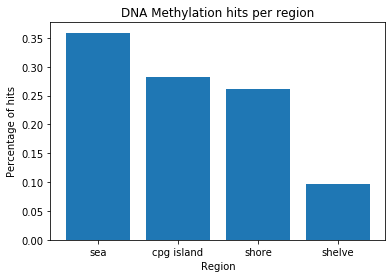

In [50]:
plt.bar(['sea','cpg island','shore','shelve'], (norm[3], norm[0], norm[1], norm[2]))
plt.title('DNA Methylation hits per region')
plt.ylabel('Percentage of hits')
plt.xlabel('Region')
plt.show()